# Reconstruction a Running Counter

In [1]:
from collections import namedtuple
import time

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

sns.set(rc={'figure.figsize': (10, 7)}, font_scale=1.5)
sns.set_style('white')

## Setup

### Data

In [2]:
RunningCounter = namedtuple('RunningCounter',
                            ['secret',  # s
                             'noise',   # z
                             'output',  #a
                             'prior_guess'])  # w

def generate_random_bits(n_bits, p=None):
    """Generte random sequence of bits in a given probaility (defualt=0.5)."""
    
    assert p is None or 0 <= p <= 1
    probs = (1-p, p) if p is not None else None
    return np.random.choice((0, 1), size=n_bits, p=probs)


def generate_running_counter(n_bits, prior=None):
    """Generate random running counter problem."""

    secret = generate_random_bits(n_bits)
    noise = generate_random_bits(n_bits)
    output = np.cumsum(secret) + noise
    
    prior_guess = (secret ^ generate_random_bits(n_bits, p=(1-prior))
                   if prior is not None else None)
    
    return RunningCounter(secret, noise, output, prior_guess)

### Attack

In [3]:
def compute_diffs(vec, up_to_delta, adjust_length=True):
    """
    Compute the all the differences vectors up to given delta.
    """

    diffs = {}
    for delta in range(1, up_to_delta+1):
        diff_result = vec[delta:] - vec[:-delta]

        # Adjust the length of all of the difference vector
        # to be the same
        # (as the shortest vector, i.e. the one with the highest delta)
        if adjust_length:
            diff_result = diff_result[up_to_delta-delta:]

        diffs[f'diff_{delta}'] = diff_result
        
    return diffs

In [4]:
def build_condition_sample_df(running_counter, delta_up_to,
                              prior=None, with_secret=False):
    """
    Build a DataFrame of the data with the differences.
    """

    samples = compute_diffs(running_counter.output,
                            delta_up_to)
    condition_cols = list(samples.keys())
    
    if with_secret:
        samples['secret'] = running_counter.secret[delta_up_to//2
                                                   :-delta_up_to//2]
    if prior is not None:
        samples['prior_guess'] = running_counter.prior_guess[delta_up_to//2
                                                             :-delta_up_to//2]
        condition_cols.append('prior_guess')

    df = pd.DataFrame(samples)
    
    return df, condition_cols

In [5]:
def learn_posterior(n_bits, delta_up_to, prior=None):
    """
    Learn empirically the posterior Pr[s | diffs, (optional prior)]."""

    simulation = generate_running_counter(n_bits,
                                          prior)
    
    samples_df, condition_cols = build_condition_sample_df(simulation, 
                                                           delta_up_to,
                                                           prior,
                                                           with_secret=True)
    
    posterior =  (samples_df
                  .groupby(condition_cols)['secret']
                  .mean()
                  .round()
                  .astype(int)
                  .rename('secret_guess')
                  .reset_index())

    return posterior

In [6]:
def perfrom_attack(rn, posterior, delta_up_to, prior=None):
    """Perform the attac on a given running counter problem."""

    rn_df, condition_cols = build_condition_sample_df(rn,
                                                      delta_up_to,
                                                      prior=prior,
                                                      with_secret=False)
    
    rn_df = rn_df.merge(posterior, how='left', on=condition_cols)

    accuracy = (rn.secret[delta_up_to//2
                          :-delta_up_to//2]
                == rn_df['secret_guess']).mean()
    
    return accuracy

## Posterior Analysis

In [7]:
DELTA_UP_TO = 4
N_BITS_PREPERATION = 10**6

In [8]:
def analyze_posterior(delta_up_to, n_bits_preperation, prior):
    """
    Print anlysis report of the posterior learning execution time and memory usage.
    """
    
    start_time = time.time()
    posterior = learn_posterior(n_bits_preperation,
                                delta_up_to,
                                prior=prior)
    end_time = time.time()
    
    execution_time = end_time - start_time
    
    n_rows, n_cols = posterior.shape
    
    n_unique_value_per_diff = {diff_name:
                               len(posterior[diff_name].unique().tolist())
                               for diff_name in posterior.loc[:,posterior.columns.str.startswith('diff')]}
    
    print(f'Execution time: {execution_time:.4f} seconds')
    print(f'Dimensions: {n_rows} rows x {n_cols} columns')
    print(f'Memroy usage: {posterior.memory_usage().sum()} Bytes')
    print(f'#Unique values per difference coulumn:\n{n_unique_value_per_diff}')

### Without Prior

In [9]:
analyze_posterior(DELTA_UP_TO, N_BITS_PREPERATION, None)

Execution time: 0.2534 seconds
Dimensions: 164 rows x 5 columns
Memroy usage: 6688 Bytes
#Unique values per difference coulumn:
{'diff_1': 4, 'diff_2': 5, 'diff_3': 6, 'diff_4': 7}


### With Prior

In [10]:
analyze_posterior(DELTA_UP_TO, N_BITS_PREPERATION, 2/3)

Execution time: 0.2434 seconds
Dimensions: 328 rows x 6 columns
Memroy usage: 15872 Bytes
#Unique values per difference coulumn:
{'diff_1': 4, 'diff_2': 5, 'diff_3': 6, 'diff_4': 7}


## Experiments

In [11]:
def estimate_accuracy(n_trials,
                      delta_up_to,
                      n_bits_data,
                      n_bits_preperation,
                      prior=None):

    """Run multiple trials of attacks on random data to estimate accuracy."""
    
    # Setup
    posterior = learn_posterior(n_bits_preperation,
                                delta_up_to,
                                prior=prior)
    
    # Run multiple independent experiments
    rn_experiments = (generate_running_counter(n_bits_data, prior)
                      for _ in range(n_trials))

    accuracies = [perfrom_attack(rn, posterior, delta_up_to, prior)
                  for rn in rn_experiments]
        
    return accuracies

In [12]:
%%time

N_TRIALS = 100
DELTA_UP_TO = 4
N_BITS_PREPERATION = 10**6

all_accuracies = {(prior, n_bits_data): estimate_accuracy(N_TRIALS,
                                    DELTA_UP_TO,
                                    n_bits_data,
                                    N_BITS_PREPERATION,
                                    prior)
                      for prior in [None, 2/3]
                      for n_bits_data in [100, 500, 1000, 5000, 50000, 100000]}

CPU times: user 12 s, sys: 1.03 s, total: 13 s
Wall time: 14.3 s


In [13]:
accuracies_df = (pd.DataFrame(all_accuracies)
                 .melt(var_name=['Prior', 'Secret Length'],
                       value_name='Accuracy'))
accuracies_df['Prior'] = accuracies_df.replace({np.nan: 'None', 2/3:'2/3'})

stats_df = (accuracies_df
            .groupby(['Prior', 'Secret Length'])['Accuracy']
            .agg(['mean', 'std']))

stats_df

mean       std
Prior Secret Length                    
2/3   100            0.827500  0.043553
      500            0.821452  0.018199
      1000           0.823845  0.012549
      5000           0.824339  0.005031
      50000          0.824490  0.001618
      100000         0.824283  0.001221
None  100            0.803021  0.036299
      500            0.805242  0.015282
      1000           0.805863  0.013265
      5000           0.804578  0.005069
      50000          0.804463  0.001736
      100000         0.804710  0.001311

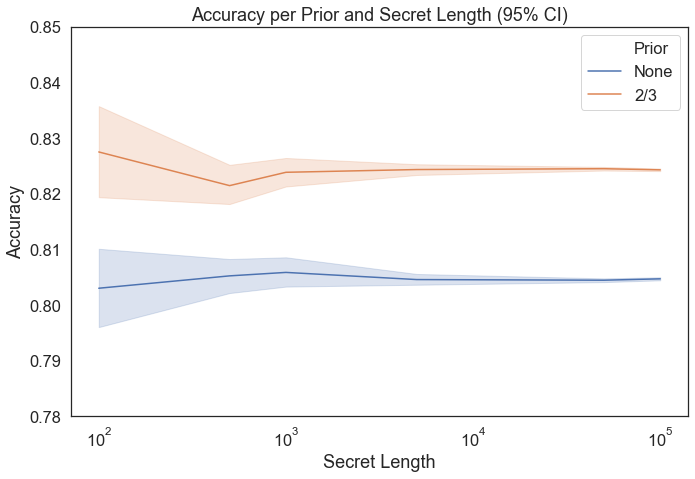

In [14]:
ax = sns.lineplot(x='Secret Length', y='Accuracy', hue='Prior',
                  ci=95, data=accuracies_df)

ax.set_title('Accuracy per Prior and Secret Length (95% CI)')
ax.set_xscale('log')
ax.set_ylim(0.78, 0.85)

plt.tight_layout()
plt.savefig('./plots/rn-acc.png', dpi=300)